In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from shapley.plots import set_style_paper, plot_sensitivity_results
set_style_paper()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from shapley.tests import AdditiveGaussian, Ishigami
from shapley.tests.utils import true_gaussian_full_ind_sobol

Model = Ishigami
corr = []
if Model == AdditiveGaussian:
    dim = 3
    beta = None
    model = Model(dim=dim, beta=beta)
    #model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.99]
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
    true_indices = {'full': true_full_indices,
                    'ind': true_ind_indices}
    model.copula_parameters = theta
elif Model == Ishigami:
    model = Model()
    dim = model.dim
    model.copula = ot.NormalCopula(dim)
    theta = [0., 0., 0.]

In [4]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

shapley_method = 'exact'

n_var = 20000
n_inner = 3
if shapley_method == 'exact':
    n_perms = None
    n_outer = 10000
else:
    n_perms = 600
    n_outer = 1

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 380000
CPU times: user 3min 41s, sys: 1min 4s, total: 4min 45s
Wall time: 1min 41s


In [5]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

CPU times: user 6.18 s, sys: 0 ns, total: 6.18 s
Wall time: 6.13 s


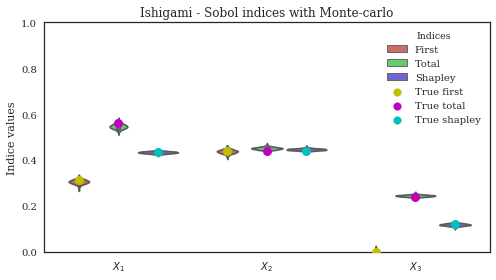

In [6]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharex=True, sharey=True)
for i, results in enumerate([shapley_results]):
    plot_sensitivity_results(results, ax=ax)
    ax.set_title("%s - Sobol indices with Monte-carlo" % (model.name))
    ax.set_ylim(ylim)
    
ax.set_xlabel('')
fig.tight_layout()

In [7]:
for results in [shapley_results]:
    print(results.full_total_indices[:, 0] - results.true_total_indices)

[-0.01296608  0.01133369  0.00526831]


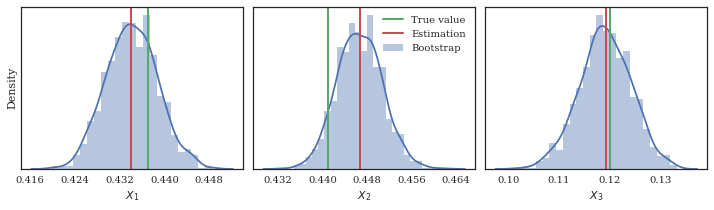

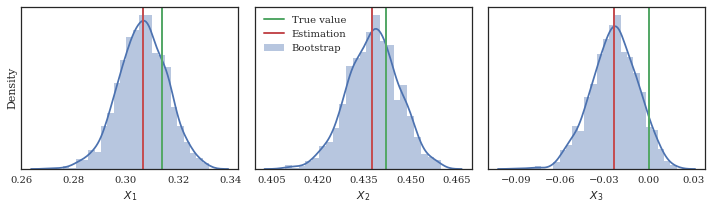

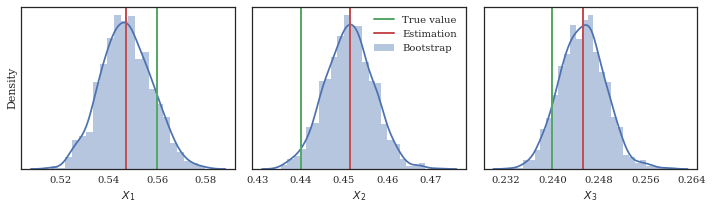

In [10]:
for j, name in enumerate(['shapley', 'first', 'total']):
    fig, axes = plt.subplots(1, dim, figsize=(10, 3), sharex='col')
    for i in range(dim):
        ax = axes[i]
        bootstrap = getattr(shapley_results, 'full_%s_indices' % (name))[i, 1:]
        true_indices = getattr(shapley_results, 'true_%s_indices' % (name))[i]
        estimation = getattr(shapley_results, 'full_%s_indices' % (name))[i, 0]

        sns.distplot(pd.DataFrame(bootstrap), norm_hist=True, ax=ax, label='Bootstrap')
        ax.plot([true_indices]*2, ax.get_ylim(), linewidth=2, label='True value')
        ax.plot([estimation]*2, ax.get_ylim(), linewidth=2, label='Estimation')
        ax.set_yticks([])
        ax.set_xlabel('$X_%d$' % (i+1))
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    axes[0].set_ylabel('Density')
    axes[1].legend(loc=0)
    fig.tight_layout(pad=1.)
    #fig.savefig('./output/bias_total_corr.pdf')